<a href="https://www.kaggle.com/code/duaanaz/face-recognition?scriptVersionId=249265968" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Load important libraries
import pandas as pd
import numpy as np

from glob import glob

import cv2,os
import matplotlib.pylab as plt

# for better visuals
plt.style.use('ggplot')

In [2]:
# Load OpenCV's pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [3]:
base_path = '../input/students-images/'
student_ids = sorted(os.listdir(base_path))

all_faces = []
labels = []
counts = {}

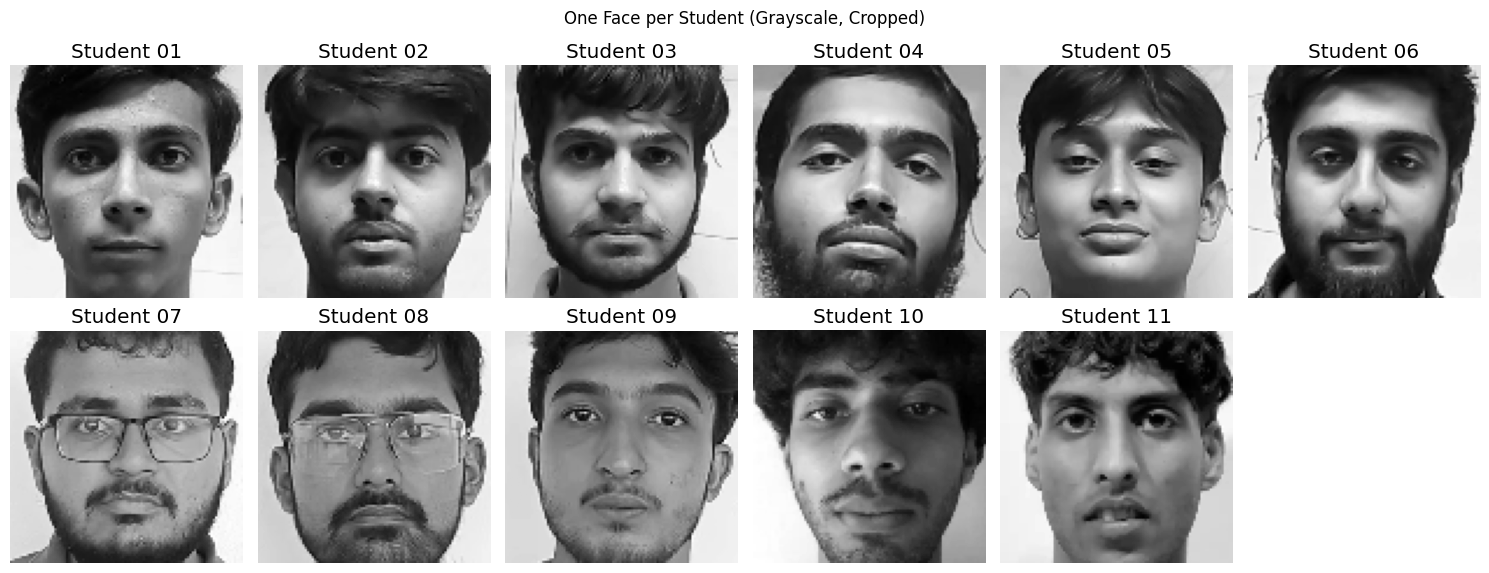

In [4]:
# Visualize 1 face per student
plt.figure(figsize=(15, 6))

for idx, student_id in enumerate(student_ids):
    image_folder = os.path.join(base_path, student_id, student_id)
    image_paths = sorted(glob(os.path.join(image_folder, '*.jpg')))
    counts[student_id] = len(image_paths)

    # Show 1 raw image and 1 face
    if idx < 12:  # display all
        img = cv2.imread(image_paths[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        # Try detecting face
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (100, 100))
        else:
            face = cv2.resize(gray, (100, 100))  # fallback

        # Show extracted face
        plt.subplot(2, 6, idx+1)
        plt.imshow(face, cmap='gray')
        plt.title(f'Student {student_id}')
        plt.axis('off')

plt.suptitle('One Face per Student (Grayscale, Cropped)')
plt.tight_layout()
plt.show()

    # Images
01       368
02       312
03       310
04       342
05       295
06       274
07       512
08       382
09       318
10       441
11       282


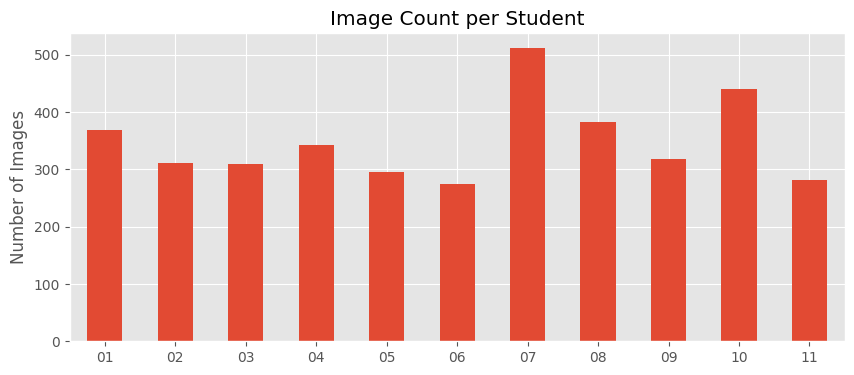

In [5]:
# Display number of images per student
count_df = pd.DataFrame.from_dict(counts, orient='index', columns=['# Images'])
print(count_df)

# Bar plot
count_df.plot(kind='bar', legend=False, figsize=(10, 4), title="Image Count per Student")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.show()

In [6]:
# extracting all faces and labels in all_faces[] and labels[] array
print("Extracting all faces and labels...")

for student_id in student_ids:
    image_folder = os.path.join(base_path, student_id, student_id)
    image_paths = sorted(glob(os.path.join(image_folder, '*.jpg')))

    for path in image_paths:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        # If a face is detected, extract the first one
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (100, 100))
            all_faces.append(face.flatten())
            labels.append(student_id)

Extracting all faces and labels...


In [7]:
# test code
print("Total faces extracted:", len(all_faces))
print("Total labels collected:", len(labels))

Total faces extracted: 3230
Total labels collected: 3230


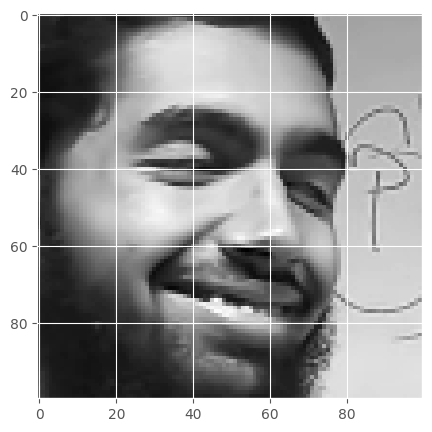

In [8]:
# this code is just for testing - will not take it forward
face_one = all_faces[1000]
reshaped=face_one.reshape(100,100)
# reshaped.shape
fig,ax=plt.subplots(figsize=(5,5))
ax.imshow(reshaped,cmap='gray')
plt.show()

In [9]:
# Data Splitting - Train&Test

from sklearn.model_selection import train_test_split

# X: all_faces as NumPy array (already flattened)
# y: encoded labels

from sklearn.preprocessing import LabelEncoder

# Re-initialize label encoder
le = LabelEncoder()
y = le.fit_transform(labels)  # labels = list of student_ids like '01', '02', etc.

X = np.array(all_faces)

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 2584
Testing samples: 646


In [10]:
# Model Training
from sklearn.svm import SVC

# Linear SVM works well for high-dimensional data like images
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

print("Training complete")


Training complete


In [11]:
# Model Testing on test data
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.2%}")

Test Accuracy: 98.61%


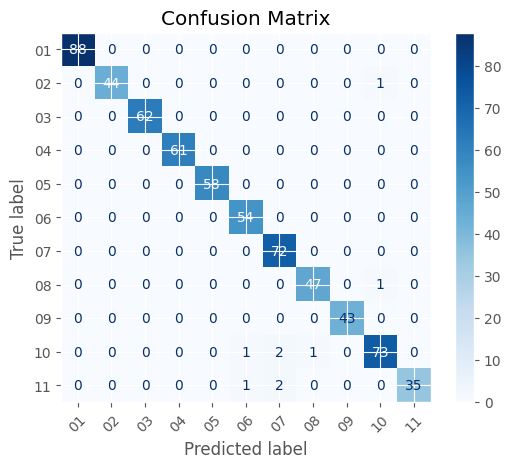

In [12]:
# Getting the confusion matrix to visualize how did the model perform on test data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [13]:
# To manually check each face
def predict_face(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    if len(faces) == 0:
        print("No face detected.")
        return
    
    (x, y, w, h) = faces[0]
    face = gray[y:y+h, x:x+w]
    face = cv2.resize(face, (100, 100)).flatten().reshape(1, -1)

    pred = model.predict(face)
    prob = model.predict_proba(face)

    student_id = le.inverse_transform(pred)[0]
    confidence = np.max(prob)

    print(f"Predicted Student: {student_id} (Confidence: {confidence:.2%})")


In [14]:
predict_face('../input/students-images/03/03/frame_00058.jpg')


Predicted Student: 03 (Confidence: 98.42%)


In [15]:
# Extra features extraction

from skimage.feature import hog

#smile red
# eyeblue nose nostril
#grreen nox
#mouth ni chal raha
#smile workssssssss, kep it stict
X_train, X_test, y_train, y_test = [], [], [], []
for student_id in student_ids:
    folder = os.path.join(base_path, student_id,student_id)
    images = sorted(glob(os.path.join(folder, '*.jpg')))
    features = []
    for path in images:
        img = cv2.imread(path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        if len(faces) == 0:
            continue
        x, y, w, h = max(faces, key=lambda r: r[2] * r[3])
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (100, 100))
        norm = face.astype('float32') / 255.0
        feat = hog(norm, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        features.append(feat)
    if len(features) >= 2:
        a, b = train_test_split(features, test_size=0.5, random_state=42)
        X_train.extend(a)
        X_test.extend(b)
        y_train.extend([student_id] * len(a))
        y_test.extend([student_id] * len(b))
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
print("Execution complete")

Execution complete


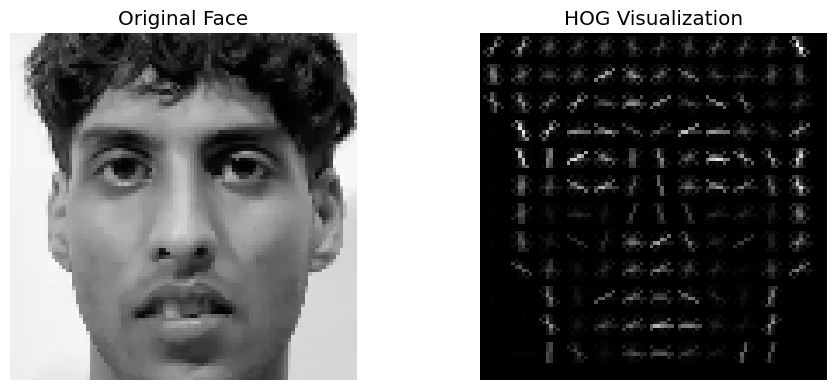

In [16]:
from skimage import exposure

img = cv2.imread(images[0])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 5)

(x, y, w, h) = max(faces, key=lambda r: r[2]*r[3])
face = gray[y:y+h, x:x+w]
face = cv2.resize(face, (100, 100))
norm = face.astype('float32') / 255.0

# HOG + visualization
features, hog_image = hog(norm, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                          visualize=True, feature_vector=True)

# Enhance contrast
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(norm, cmap='gray')
plt.title("Original Face")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Visualization")
plt.axis('off')
plt.tight_layout()
plt.show()